In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Libraries
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

In [ ]:
def preprocess_data(file_path):
  """function that preprocesses the data from the dataset"""
  df = pd.read_csv(file_path)
  # Remove all NaN-containing entries
  df = df.dropna()
  # Reformat the timestamp
  df['Timestamp'] = pd.to_datetime(df['Timestamp'],
  infer_datetime_format=True, unit='s')
  # Use the timestamp as index column
  df = df.set_index('Timestamp')
  # Narrow the scope of dataframe columns to work with
  df = df.drop(['Low', 'High', 'Volume_(BTC)', 'Weighted_Price'], 
               axis=1)
  # Reorder columns
  df = df.reindex(columns=['Open', 'Close', 'Volume_(Currency)'])
  # Work on a 1hour window
  df['Open'] = df['Open'].resample('1H').first()
  df['Close'] = df['Close'].resample('1H').last()
  df['Volume_(Currency)'] = df['Volume_(Currency)'].resample('1H').sum()
  # Remove all NaN-containing entries
  df = df.dropna()
  # Remove the first half of the dataframe (given data sparsity)
  df = df.iloc[-int((df.shape[0]/2)):]
  print(df.head(10))
  print('=======================')
  # Create the dataset (np.ndarray of "df.shape")
  dataset = df.values
  print(dataset[:10])
  print(dataset.shape)
  print('=======================')
  # Standardize the dataset
  mean = np.mean(dataset, axis=0)
  stddev = np.std(dataset, axis=0)
  dataset = (dataset - mean) / stddev
  print(dataset[:10])
  print(dataset.shape)
  print('=======================')
  def split_sequence(sequence, n_steps):
    """function that splits a dataset sequence into input data and
    labels"""
    X, Y = [], []
    for i in range(sequence.shape[0]):
      if (i + n_steps) >= sequence.shape[0]:
        break
      # Divide sequence between data (input) and labels (output)
      seq_X, seq_Y = sequence[i: i + n_steps],sequence[i + n_steps, -2]
      X.append(seq_X)
      Y.append(seq_Y)
    return np.array(X), np.array(Y)
  # Create training and validation datasets
  dataset_size = dataset.shape[0]
  x_train, y_train = split_sequence(dataset[0: math.ceil(0.7 *
                                    dataset_size)], 24)
  x_val, y_val = split_sequence(dataset[math.floor(0.7 *
                                dataset_size):], 24)
  return dataset, df, x_train, y_train, x_val, y_val

file_path = '/content/drive/MyDrive/Tugas 2 JST/LSTM/Multivariate/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
dataset, df, x_train, y_train, x_val, y_val = preprocess_data(file_path)
print("dataset.shape: {}".format(dataset.shape))
print("df.shape: {}".format(df.shape))
print("x_train.shape: {}".format(x_train.shape))
print("y_train.shape: {}".format(y_train.shape))
print("x_val.shape: {}".format(x_val.shape))
print("y_val.shape: {}".format(y_val.shape))
print('=======================')

                        Open    Close  Volume_(Currency)
Timestamp                                               
2017-08-07 01:00:00  3200.00  3197.00       6.449428e+05
2017-08-07 02:00:00  3197.00  3227.02       6.213511e+05
2017-08-07 03:00:00  3219.00  3247.41       5.847476e+05
2017-08-07 04:00:00  3245.01  3216.99       4.127770e+05
2017-08-07 05:00:00  3219.23  3243.39       6.735666e+05
2017-08-07 06:00:00  3254.99  3253.00       7.296353e+05
2017-08-07 07:00:00  3252.96  3242.25       7.082939e+05
2017-08-07 08:00:00  3232.34  3260.00       8.043031e+05
2017-08-07 09:00:00  3260.00  3275.89       1.178991e+06
2017-08-07 10:00:00  3275.89  3280.00       1.014192e+06
[[   3200.            3197.          644942.75388196]
 [   3197.            3227.02        621351.10804698]
 [   3219.            3247.41        584747.58448721]
 [   3245.01          3216.99        412777.01029883]
 [   3219.23          3243.39        673566.60500307]
 [   3254.99          3253.          729635.34

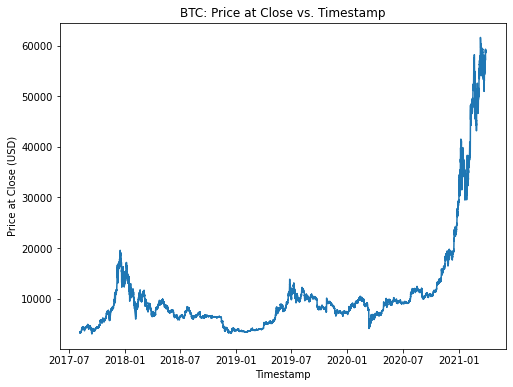

In [ ]:
def plot_0(df, title):
  """function that plots Price at Close vs. Timestamp"""
  plt.figure(figsize=(8,6))
  plt.plot(df)
  plt.title(title)
  plt.xlabel('Timestamp')
  plt.ylabel('Price at Close (USD)')

  plt.show()
plot_0(df['Close'], 'BTC: Price at Close vs. Timestamp')

In [ ]:
batch_size = 256
buffer_size = x_train.shape[0]
# Provide an infinite dataset
train_iterator = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).repeat()

In [ ]:
#Build Model
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(n_steps, n_features))))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 10
steps_per_epoch = 100
validation_steps = 10
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.save("multivariate.h5")
model.summary()

Epoch 1/10
100/100 [==============================] - 11s 81ms/step - loss: 0.0504 - val_loss: 5.7165e-04
Epoch 2/10
100/100 [==============================] - 8s 78ms/step - loss: 6.3867e-04 - val_loss: 4.6550e-04
Epoch 3/10
100/100 [==============================] - 8s 78ms/step - loss: 4.7779e-04 - val_loss: 3.7370e-04
Epoch 4/10
100/100 [==============================] - 8s 78ms/step - loss: 3.8454e-04 - val_loss: 3.0731e-04
Epoch 5/10
100/100 [==============================] - 8s 78ms/step - loss: 3.0693e-04 - val_loss: 2.8643e-04
Epoch 6/10
100/100 [==============================] - 8s 78ms/step - loss: 2.5357e-04 - val_loss: 2.3741e-04
Epoch 7/10
100/100 [==============================] - 8s 79ms/step - loss: 2.2693e-04 - val_loss: 2.0863e-04
Epoch 8/10
100/100 [==============================] - 8s 79ms/step - loss: 2.2521e-04 - val_loss: 2.6408e-04
Epoch 9/10
100/100 [==============================] - 8s 80ms/step - loss: 2.0602e-04 - val_loss: 1.8330e-04
Epoch 10/10
100/100 [=

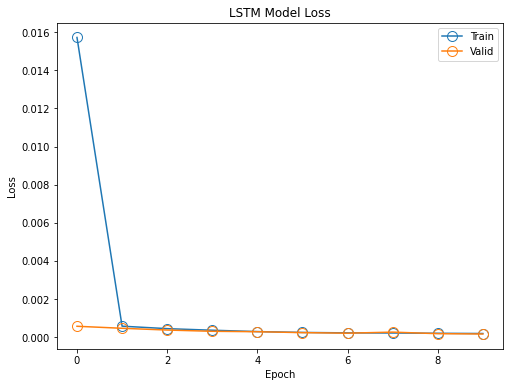

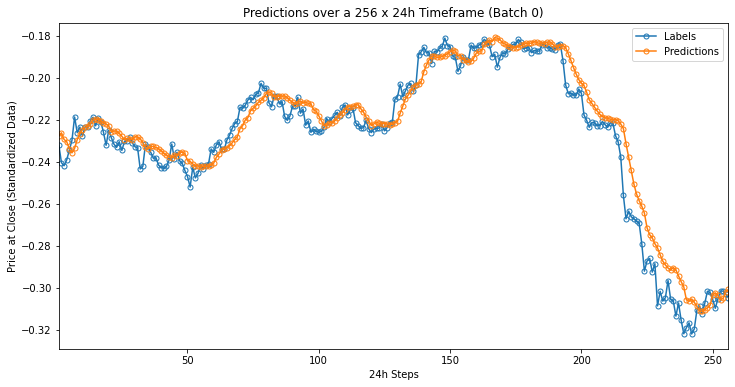

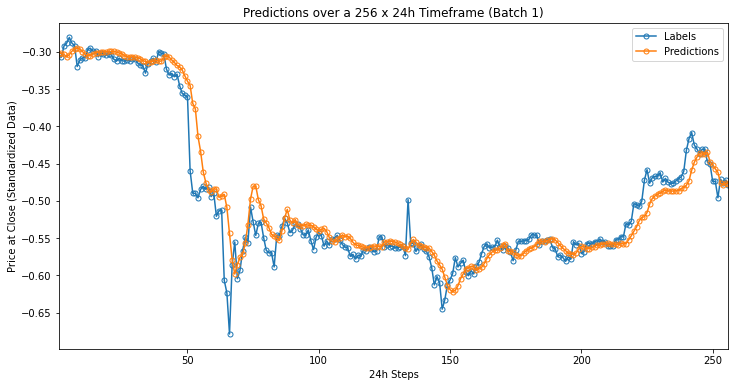

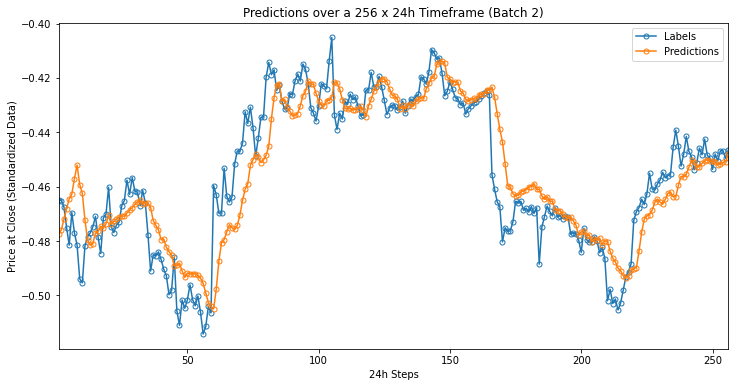

In [ ]:
#Plot Grafik
def plot_1(history, title):
  """function that plots the loss results of the model"""
  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'], 'o-', mfc='none', markersize=10, 
  label='Train')
  plt.plot(history.history['val_loss'], 'o-', mfc='none', 
  markersize=10, label='Valid')
  plt.title('LSTM Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_2(data_24h, single_label, single_prediction, title):
  """function that plots a single-step price prediction following 
  24h of data"""
  time_steps = list(range(24))
  next_step = 24
  plt.figure(figsize=(8, 6))
  plt.plot(time_steps, data_24h, 'o-', markersize=8, 
  label='data_24h')
  plt.plot(next_step, single_label, 'b+', mfc='none', markersize=12, 
  label='Label')
  plt.plot(next_step, single_prediction, 'ro', mfc='none', 
  markersize=12, label='Prediction')
  plt.title(title)
  plt.xlabel('Time Steps')
  plt.ylabel('Price at Close (Standardized Data)')
  plt.legend()
  plt.show
def plot_3(future, prediction, title):
  """function that plots predictions over "batch_size" x 24h 
  timeframes"""
  days = list(range(1, future.shape[0] + 1))
  plt.figure(figsize=(12, 6))
  plt.plot(days, future, 'o-', markersize=5, mfc='none', 
  label='Labels')
  plt.plot(days, prediction, 'o-', markersize=5, mfc='none', 
  label='Predictions')
  plt.title(title)
  plt.xlim([days[0], days[-1]])
  plt.xlabel('24h Steps')
  plt.ylabel('Price at Close (Standardized Data)')
  plt.legend()
  plt.show
# Plot the model loss results
plot_1(history, 'Training / Validation Losses from History')
# Make a single-step price prediction following 24h of data
window_num = 0
# Make predictions over "batch_size" x 24h timeframes
string = 'Predictions over a {} x 24h Timeframe (Batch {})'
for batch_num, (x, y) in enumerate(val_iterator.take(3)):
  title = string.format(batch_size, batch_num)
  plot_3(y.numpy(),
         model.predict(x).reshape(-1),
         title)
  batch_num += 1